# Image Classification with GluonCV


## Configuration

Install GluonCV through `pip`

In [1]:
!pip install gluoncv

mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
mxnet-cu90mkl 1.3.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.20.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Import necessary modules

In [2]:
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import makedirs, download
from gluoncv.model_zoo import get_model

## Predict with Pre-trained Models

Let's load an image first.

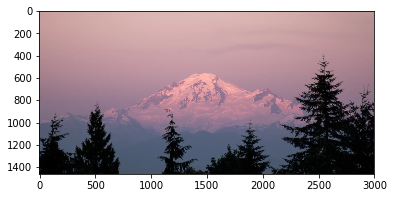

In [3]:
download('https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/mt_baker.jpg', path='./')
filename = 'mt_baker.jpg'
img = mx.image.imread(filename)
plt.imshow(img.asnumpy())

Choose a good model, load pre-trained weights with `pretrained=True`.

In [4]:
model_name = 'ResNet50_v1'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

Preprocess the image with the preset transformations.

In [5]:
transformed_img = gluoncv.data.transforms.presets.imagenet.transform_eval(img)

How does the transformed image look like?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


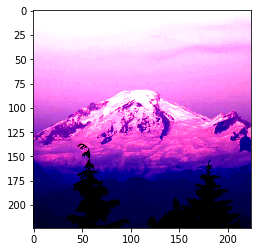

In [6]:
import numpy as np
plt.imshow(np.transpose(transformed_img[0].asnumpy(), (1, 2, 0)))

The transformation does the following two things:

1. Crop the center square
2. Normalizes the input image

With this, we can predict with one line of code:

In [7]:
pred = net(transformed_img)

Check the top-5 predicted classes.

In [8]:
prob = mx.nd.softmax(pred)[0].asnumpy()
ind = mx.nd.topk(pred, k=5)[0].astype('int').asnumpy().tolist()
print('The input picture is classified to be')
for i in range(5):
    print('- [%s], with probability %.3f.'%(net.classes[ind[i]], prob[ind[i]]))

The input picture is classified to be
- [volcano], with probability 0.653.
- [alp], with probability 0.132.
- [mountain tent], with probability 0.013.
- [valley], with probability 0.010.
- [lakeside], with probability 0.006.


We see the model gives the correct result. How about a smaller one?

You only need to change the name of the model from the above code.

In [9]:
model_name = 'MobileNet0.25'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)
pred = net(transformed_img)
prob = mx.nd.softmax(pred)[0].asnumpy()
ind = mx.nd.topk(pred, k=5)[0].astype('int').asnumpy().tolist()
print('The input picture is classified to be')
for i in range(5):
    print('- [%s], with probability %.3f.'%(net.classes[ind[i]], prob[ind[i]]))

The input picture is classified to be
- [volcano], with probability 0.178.
- [alp], with probability 0.166.
- [lakeside], with probability 0.048.
- [valley], with probability 0.035.
- [mountain tent], with probability 0.025.


The smaller model is not that confident, but still gives a good enough prediction.

## Transfer Learning with your own data

Now we are going to demonstrate how to transfer the knowledge from pre-trained model to your own domain.

We use a sampled smaller dataset in this tutorial. Introduction to the entire dataset can be found at [this page](https://gluon-cv.mxnet.io/build/examples_classification/transfer_learning_minc.html#data-preparation).

In [10]:
file_url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/minc-2500-tiny.zip'
zip_file = download(file_url, path='./')
with zipfile.ZipFile(zip_file, 'r') as zin:
    zin.extractall(os.path.expanduser('./'))

Next we prepare the hyperparameters.

In [11]:
classes = 23

epochs = 5
lr = 0.001
per_device_batch_size = 1
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

Next, transformation, which is the preprocessing.
We implement the same preprocessing function as ImageNet.

Note: keep the transformation consistent with the original model training is important in transfer learning.

In [12]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256, keep_ratio=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Now we can load the data into train, validation, and test.

For validation and test, we use the same transformation.

In [13]:
path = './minc-2500-tiny'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

Now the data is prepared. We define the model, then 

In [14]:
model_name = 'MobileNet1.0'
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

# Trainer, metric, loss
trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

Next, a function to measure the performance on validation and test dataset.

In [15]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

Finally we can start our training! 

In [16]:
lr_counter = 0
num_batch = len(train_data)

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.026, loss: 3.459 | Val-acc: 0.087 | time: 4.2
[Epoch 1] Train-acc: 0.026, loss: 3.387 | Val-acc: 0.043 | time: 2.4
[Epoch 2] Train-acc: 0.035, loss: 3.257 | Val-acc: 0.043 | time: 2.4
[Epoch 3] Train-acc: 0.035, loss: 3.212 | Val-acc: 0.043 | time: 3.0
[Epoch 4] Train-acc: 0.052, loss: 3.117 | Val-acc: 0.022 | time: 2.5
[Finished] Test-acc: 0.022


Although this is a small example, it is basically how we train a model on much larger dataset.

## Further resources

On the GluonCV Classification Model Zoo page, we provide:

- Training scripts for ImageNet and CIFAR10.
- Training hyperparameters to reproduce.
- Training Logs to compare speed and accuracy.